## Install

In [1]:
# !apt install tesseract-ocr
# !apt install libtesseract-dev

In [2]:
# !pip install layoutparser
# !pip install layoutparser[ocr]
# !pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'
# !pip install pytesseract
# !pip install pymupdf
# !pip install python-docx

## Imports

In [3]:
import pymupdf
import layoutparser as lp
import pytesseract
import cv2
import numpy as np
from collections import namedtuple
from PIL import Image

from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import RGBColor

## Get pages-images from pdf

In [4]:
def pix_to_image(pix):
    """
    Convert a pixmap object to an image array.

    Parameters:
    pix (fitz.Pixmap): A pixmap object representing a page image from a PDF.

    Returns:
    numpy.ndarray: An image array with shape (height, width, channels),
                   where 'height' is the number of rows,
                   'width' is the number of columns,
                   and 'channels' is the number of color channels.
    """
    bytes = np.frombuffer(pix.samples, dtype=np.uint8)
    img = bytes.reshape(pix.height, pix.width, pix.n)
    return img

def pdf_to_images(filename, save_to_files=True):
    """
    Process a PDF file and return a list of page images.

    Parameters:
    filename (str): The name of the PDF file to process.
    save_to_files (bool): Whether to save the pages as image files. Default is True.

    Returns:
    list: A list of pixmap objects representing the pages.
    """
    doc = pymupdf.open(filename)  # open document
    pages = []

    for page in doc:  # iterate through the pages
        pix = page.get_pixmap()  # render page to an image
        image = pix_to_image(pix)
        pages.append(image)

        if save_to_files:
            pix.save(f"page_{page.number}.jpg")  # save image to file

    return pages

In [6]:
file_name = 'Scan.pdf'
pages = pdf_to_images(file_name)
print(f'Number of pages in `{file_name}` is {len(pages)}')

Number of pages in `Scan.pdf` is 7


## Get layouts from images deep learning pretatined model
[There are a lot of models
](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html#model-catalog)<p>
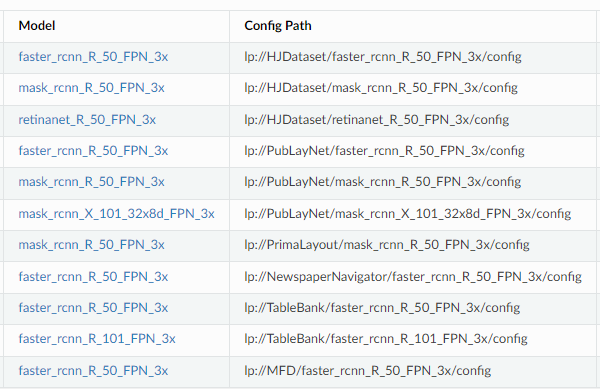

In [17]:
model = lp.models.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

config.yml?dl=1: 8.19kB [00:01, 4.17kB/s]
model_final.pth?dl=1: 330MB [00:12, 25.5MB/s]                           


In [20]:
from tqdm.notebook import tqdm

layouts = []
for image in tqdm(pages):
  layout = model.detect(image)
  layouts.append(layout)
  # lp.draw_box(image, layout, box_width=2, show_element_id=True, show_element_type=True)

  0%|          | 0/7 [00:00<?, ?it/s]

### Some Examples

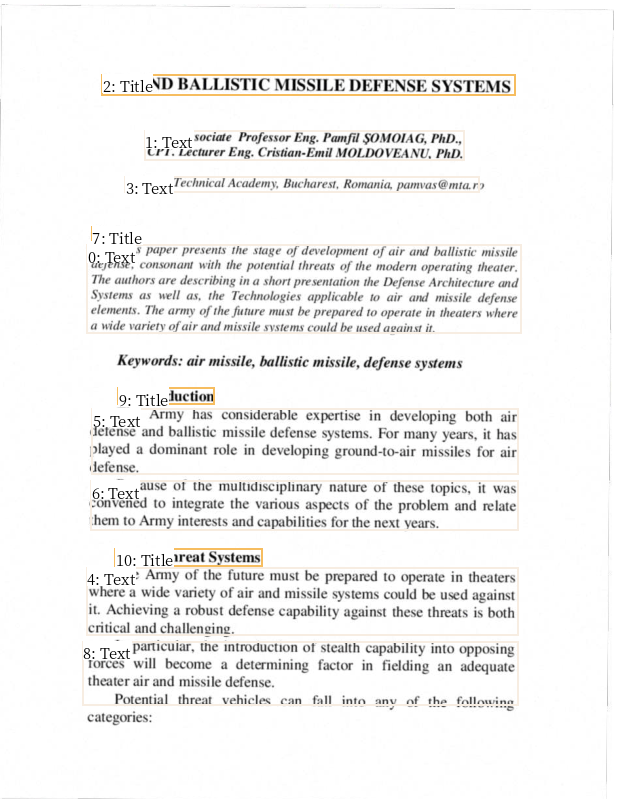

In [ ]:
lp.draw_box(pages[1], layouts[1], box_width=2, show_element_id=True, show_element_type=True)

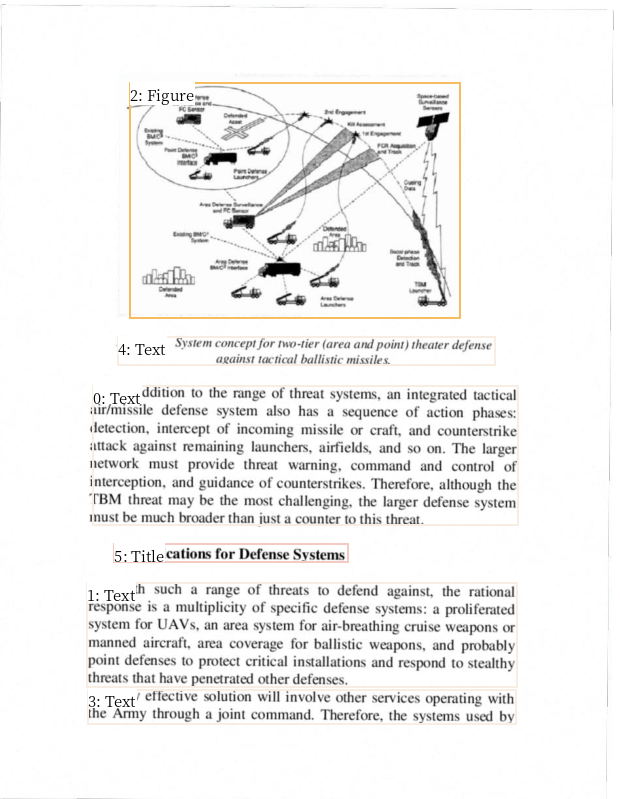

In [21]:
lp.draw_box(pages[3], layouts[3], box_width=2, show_element_id=True, show_element_type=True)

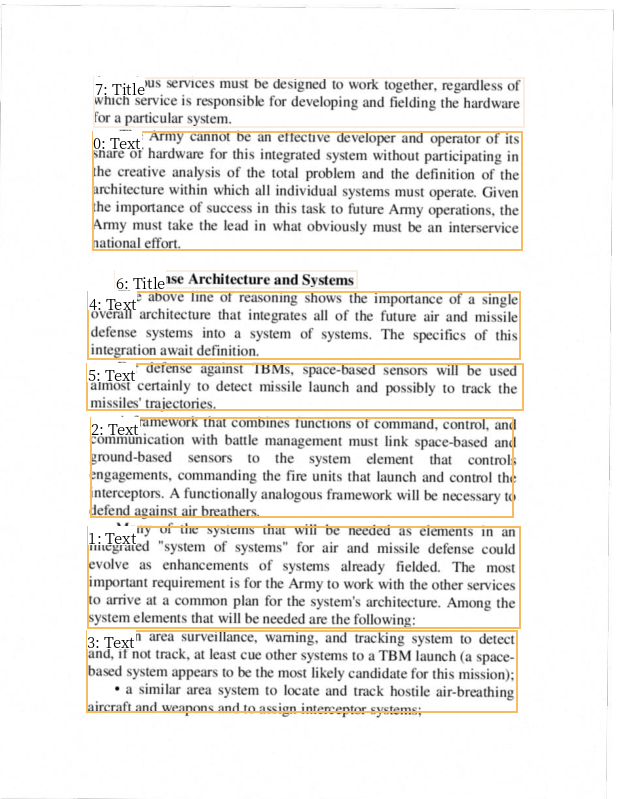

In [22]:
lp.draw_box(pages[4], layouts[4], box_width=2, show_element_id=True, show_element_type=True)

## Get sorted blocks from images

In [23]:
pages_blocks = []
h, w = pages[0].shape[:2]

for idx, layout in enumerate(layouts):
  text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
  title_blocks = lp.Layout([b for b in layout if b.type=='Title'])
  figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])
  list_blocks = lp.Layout([b for b in layout if b.type=='List'])
  # table_blocks = lp.Layout([b for b in layout if b.type=='Table'])

  left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(pages[idx])
  left_blocks = (text_blocks+title_blocks+figure_blocks+list_blocks).filter_by(left_interval, center=True)
  left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

  right_blocks = lp.Layout([b for b in (text_blocks+title_blocks+figure_blocks+list_blocks) if b not in left_blocks])
  right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

  # And finally combine the two lists and add the index
  all_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])
  pages_blocks.append(all_blocks)

assert len(pages) == len(pages_blocks), 'num pages not equal num pages_blocks'


### Print some examples

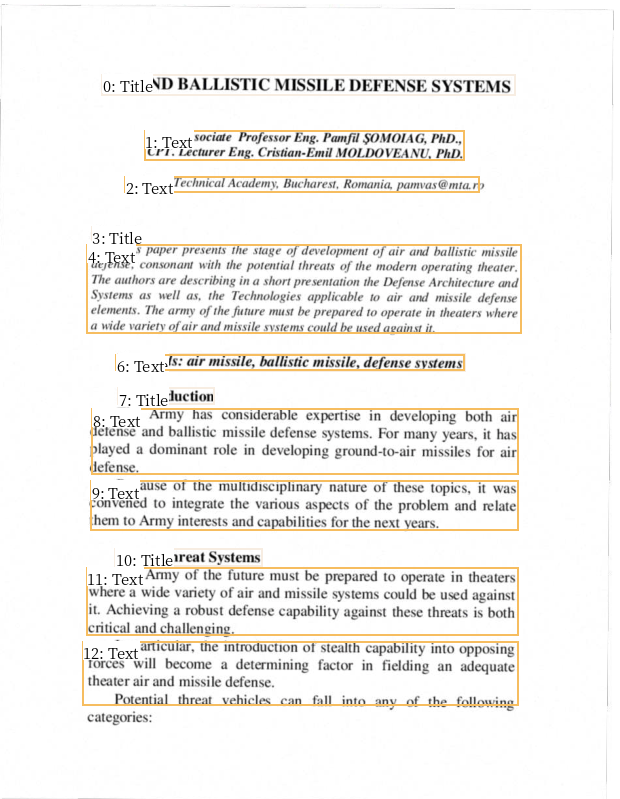

In [25]:
lp.draw_box(pages[1], pages_blocks[1], box_width=2, show_element_id=True, show_element_type=True)

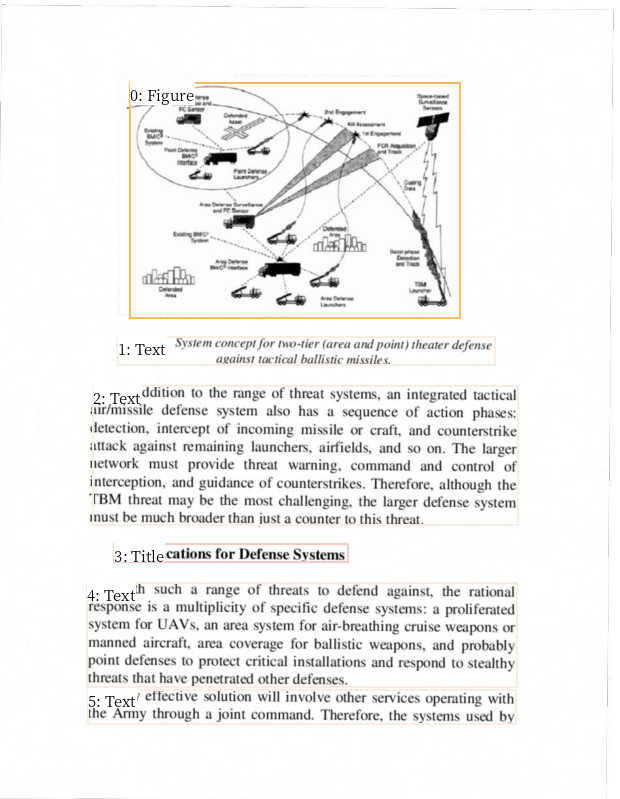

In [26]:
lp.draw_box(pages[3], pages_blocks[3], box_width=2, show_element_id=True, show_element_type=True)

## Pages OCR

In [27]:
def create_page_dict(text_blocks):
    """
    Create a dictionary from a list of text blocks.

    Each text block is assigned a unique key in the format '<type><index>',
    where 'type' is the type of the text block (converted to lowercase)
    and 'index' is the position of the text block in the list.
    The text of each block is stripped of leading and trailing whitespace
    and newlines are replaced with spaces.

    Parameters:
    text_blocks (list): A list of text block objects, each containing 'type' and 'text' attributes.

    Returns:
    dict: A dictionary where the keys are unique identifiers for each text block
          and the values are the cleaned text of the blocks.
    """
    page_dict = {}
    count = 0

    for txt in text_blocks:
        key = f'{txt.type.lower()}{count}'
        if key.startswith('figure'):
            Coords = namedtuple('Coords', ['x1', 'y1', 'x2', 'y2'])
            x1=int(txt.block.x_1)
            y1=int(txt.block.y_1)
            x2=int(txt.block.x_2)
            y2=int(txt.block.y_2)
            value = Coords(x1=x1, x2=x2, y1=y1, y2=y2)
        else:
          value = txt.text.strip().replace('\n', ' ')
        page_dict[key] = value
        count += 1

    return page_dict

In [29]:
# create tesseract agent
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
ocr_agent = lp.TesseractAgent(languages='eng')

In [30]:
texts_of_pages = {} # dict for collect reconized pages

for idx, page in tqdm(enumerate(pages_blocks)):
  if page:
    for block in page:
# add padding in each image segment can help improve robustness
      segment_image = (block
                        .pad(left=5, right=5, top=5, bottom=5)
                        .crop_image(pages[idx]))


      text = ocr_agent.detect(segment_image)
      block.set(text=text, inplace=True)
    texts_of_pages[f'Page_{idx}'] = create_page_dict(page)

0it [00:00, ?it/s]

In [31]:
# dict of dicts with keys as number of page and
# values as dict with recornized blocks
import pprint

pprint.pprint(texts_of_pages, sort_dicts=False)

{'Page_1': {'title0': 'AIR AND BALLISTIC MISSILE DEFENSE SYSTEMS',
            'text1': 'LTC. Associate Professor Eng. Pamfil SOMOIAG, PhD., CPT. '
                     'Lecturer Eng. Cristian-Emil MOLDOVEANU, PhD.',
            'text2': 'Military Technical Academy, Bucharest, Romania, '
                     'pamvas@mta.ré',
            'title3': 'Abstract',
            'text4': 'This paper presents the stage of development of air and '
                     'ballistic missile defense, consonant with the potential '
                     'threats of the modern operating theater. The authors are '
                     'describing in a short presentation the Defense '
                     'Architecture and Systems as well as, the Technologies '
                     'applicable 1 air and missile defense elements. The army '
                     'of the future must be prepared to operate in theaters '
                     'where 4 wide variety of air and missile systems could be '
          

## Create docx-file

In [33]:
doc = Document()
sections = doc.sections
# define page margins
for section in sections:
    section.top_margin = Inches(1)
    section.bottom_margin = Inches(1)
    section.left_margin = Inches(1)
    section.right_margin = Inches(1)


def create_docx_from_dict(data, filename='output.docx', indent_cm=1, font_size=14):


    # define font style
    style = doc.styles['Normal']
    font = style.font
    font.name = 'Times New Roman'
    font.size = Pt(font_size)
    font.color.rgb = RGBColor(0, 0, 0)  # Black color

    for page in texts_of_pages:
        texts = texts_of_pages[page]
        for key, value in texts.items():
            if key.startswith('title'):
                # add a subsection
                paragraph = doc.add_paragraph()
                run = paragraph.add_run(value)
                run.bold = True
                paragraph_format = paragraph.paragraph_format
                paragraph_format.first_line_indent = Inches(indent_cm * 0.3937)
                paragraph_format.space_before = Inches(indent_cm * 0.3937/3)  # Indent before a paragraph

            elif key.startswith('text'):
                # Додаємо текст
                paragraph = doc.add_paragraph(value)
                paragraph_format = paragraph.paragraph_format
                paragraph_format.first_line_indent = Inches(indent_cm * 0.3937)
                paragraph.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
                # paragraph_format.space_before = Inches(indent_cm * 0.3937/3)  # Indent before a paragraph
                # paragraph_format.space_after = Inches(indent_cm * 0.3937)  # Відступ після параграфу

            elif key.startswith('figure'):
                # create np.array with figure using coordinates of figure block
                fig = np.array(pages[int(f'{page[-1]}')])[value.y1: value.y2, value.x1: value.x2]
                figname = 'fig.jpg'
                Image.fromarray(fig).save(figname)
                # add a figure
                paragraph = doc.add_paragraph()
                paragraph_format = paragraph.paragraph_format
                paragraph_format.space_after = Inches(indent_cm * 0.3937/3)  # Indent after a paragraph
                paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
                run = paragraph.add_run()
                run.add_picture(figname, width=Inches(4))

            # Add a page break
        doc.add_page_break()

    # remove the last page break, which may be added unnecessarily
    if doc.paragraphs[-1].text == '':
        doc.paragraphs[-1].clear()

    # saving doc
    doc.save(filename)


create_docx_from_dict(texts_of_pages, filename='output.docx', indent_cm=1)